# My Project- Daniel Bose
# Precipitation in Southern Africa and its Relationship with SST
### Using SST Data to Predict Southern African Rainfall during the Austral Summer

In [3]:
# Load Packages
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.patches as patches
import cartopy.feature as cfeature

# El Nino Southern Oscillation
#### and its relationship between SST and Austral Summer Precipitation in Southern Africa
#### The ENSO is region of strong teleconnections with precipitation as abnormal warming (El Nino) distrupts the Walker Circulation over the Pacific Ocean which affects the monsoon in Eastern Asia, India, and Africa among other teleconnections. An abnormal cooling (La Nina) in this region strengthens the Walker Circulation, increasing precipitation.

In [4]:
#Load and Preprocess Data
#ECMWF Reanalysis Data (ERA5), then created a SST anomalies dataset
mon_sst_anom = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_sst_month_anom.nc')

mon_sst_anom =  mon_sst_anom.sortby('valid_time')

mon_sst_anom = mon_sst_anom.rename({'valid_time': 'date'})

new_dates = pd.to_datetime(mon_sst_anom.coords['date']).to_period('M').start_time
mon_sst_anom = mon_sst_anom.assign_coords(date=new_dates)

In [5]:
mon_sst_anom

<xarray.Dataset> Size: 4GB
Dimensions:    (date: 972, latitude: 721, longitude: 1440)
Coordinates:
    number     (date) int64 8kB ...
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    surface    (date) float64 8kB ...
    month      (date) int64 8kB ...
  * date       (date) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2020-12-01
Data variables:
    sst        (date, latitude, longitude) float32 4GB ...

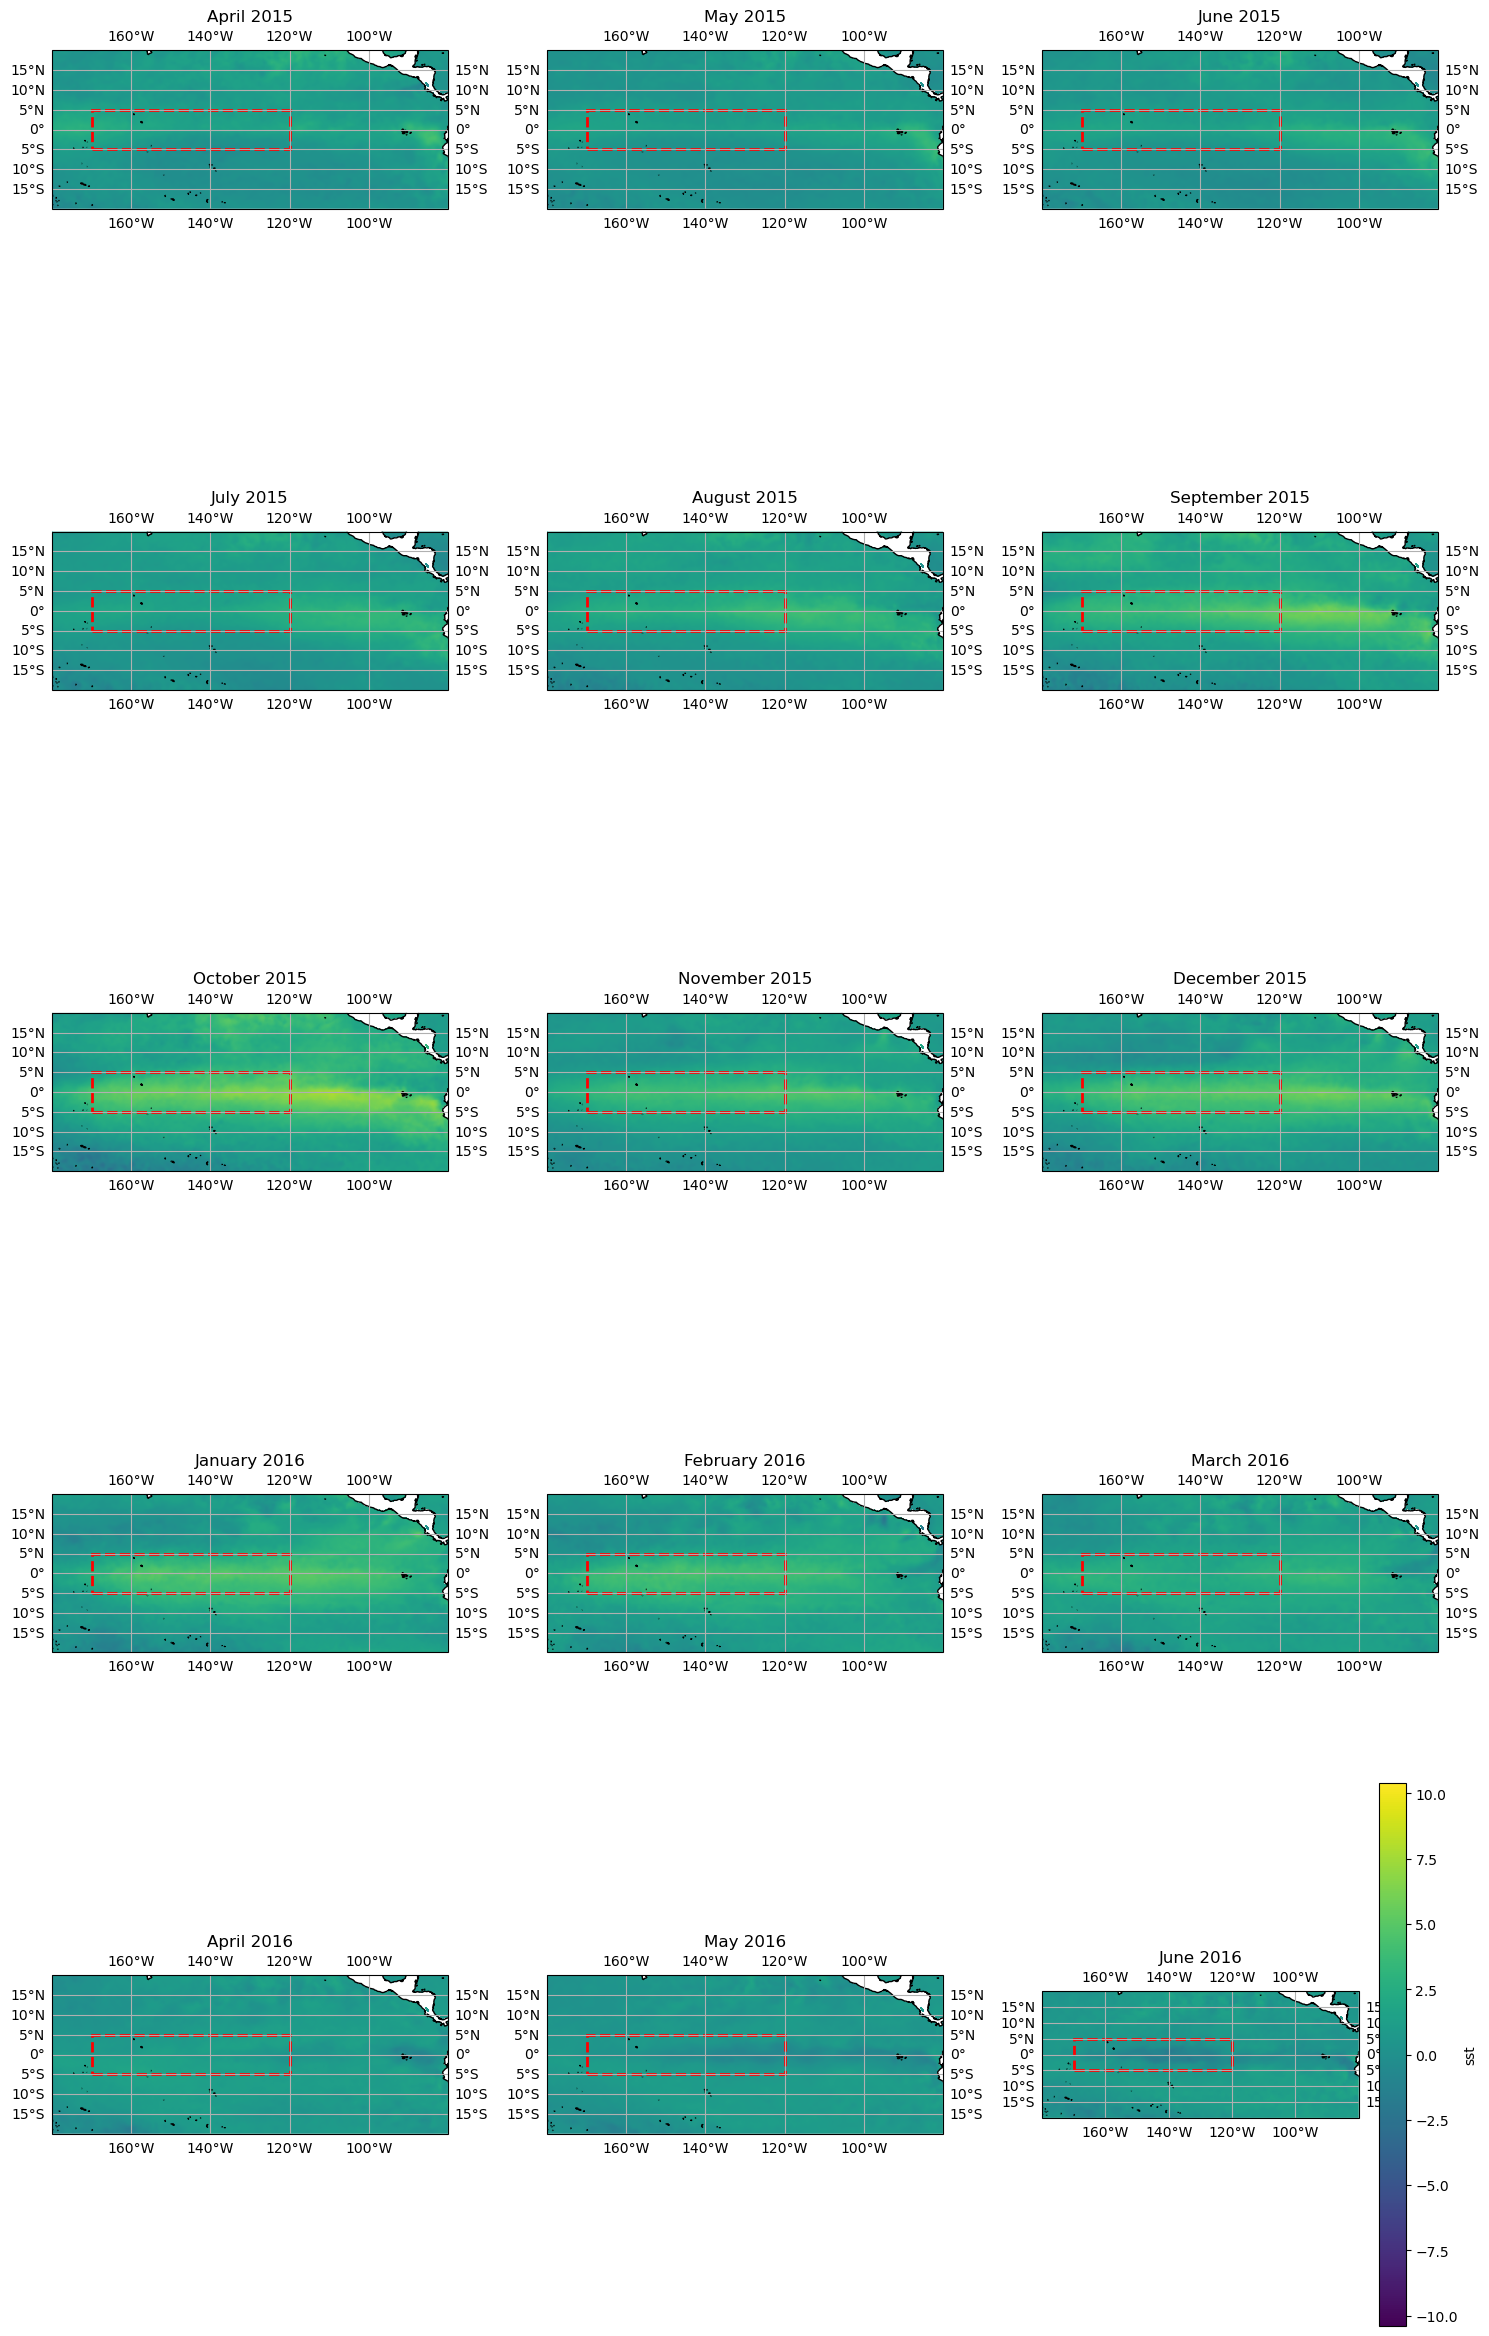

In [6]:
#I wanted to look at 2016 which was a very strong El Nino
anomalies_selected = mon_sst_anom['sst'].sel(date=slice('2015-04', '2016-06'))

# Set up the figure and axes for the panel plot
n_month = 15
n_rows = 5  # Number of rows
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten axes for easy iteration
axes = axes.flatten()

# Define the extent for the equatorial Pacific
extent = [-180, -80, -20, 20]  

# Iterate through each month and plot
for i in range(n_month):
    ax = axes[i]
    anomalies_selected[i].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=(i == 14))
    ax.coastlines()
    ax.set_extent(extent, crs=ccrs.PlateCarree())  # Set the extent for the equatorial Pacific
    ax.gridlines(draw_labels=True)
    ax.set_title(anomalies_selected.date[i].dt.strftime('%B %Y').item())  # Set title with month and year
    
    #Nino 3.4 Region which goes from 190°E to 240°E and 5°S to 5°N
    nino34_box = patches.Rectangle(
            (-170, -5),  # Lower left corner (lon, lat)
            50,          # Width (lon_max - lon_min)
            10,          # Height (lat_max - lat_min)
            linewidth=2,
            edgecolor='red',
            facecolor='none',
            linestyle='--'
        )
    ax.add_patch(nino34_box)
    
# Adjust layout
plt.tight_layout()
plt.show()


In [7]:
#Bring in Preciptation Data
mon_precip_sa = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_mon_precip_sa.nc')

mon_precip_sa['date'] = pd.to_datetime(mon_precip_sa['date'].values.astype(str), format='%Y%m%d')

mon_precip_sa

<xarray.Dataset> Size: 66MB
Dimensions:    (date: 972, latitude: 141, longitude: 121)
Coordinates:
    number     int64 8B ...
  * date       (date) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2020-12-01
  * latitude   (latitude) float64 1kB 0.0 -0.25 -0.5 ... -34.5 -34.75 -35.0
  * longitude  (longitude) float64 968B 10.0 10.25 10.5 ... 39.5 39.75 40.0
    expver     (date) <U4 16kB ...
Data variables:
    tp         (date, latitude, longitude) float32 66MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-11T20:12 GRIB to CDM+CF via cfgrib-0.9.1...

### Now, we want to look at only the Nino 3.4 Region

In [8]:
nino34 = mon_sst_anom['sst'].sel(
    longitude=slice(190, 240),  # Longitude range
    latitude=slice(5, -5)         # Latitude range
)


mean_nino34 = nino34.mean(dim=('latitude', 'longitude'))

### Let us take a look at the Nino 3.4 Average Temperature over Time
#### Note: This is not the ENSO Index, which it is a 30-year rolling average which I did not do because I would have lost 30 years worth of data.

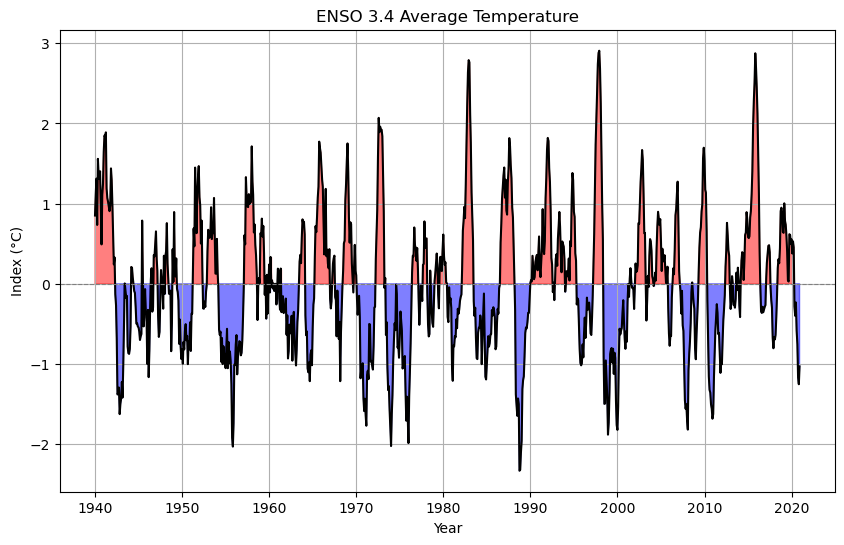

In [9]:
plt.figure(figsize=(10, 6))

# Plot the SST anomalies
plt.plot(mean_nino34['date'], mean_nino34, color='black')

# Fill areas above and below zero
plt.fill_between(mean_nino34['date'], mean_nino34, 0, where=(mean_nino34 > 0), color= 'red', alpha=0.5)
plt.fill_between(mean_nino34['date'], mean_nino34, 0, where=(mean_nino34 < 0), color='blue', alpha=0.5)

# Add labels and title
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
plt.title('ENSO 3.4 Average Temperature')
plt.xlabel('Year')
plt.ylabel('Index (°C)')
plt.grid()

# Show the plot
plt.show()

### For this study, I want to focus on wintertime precipitation (Austral Summer)

In [10]:

o_f_nino34 = mean_nino34.sel(date=(mean_nino34['date.month'] >= 10) | (mean_nino34['date.month'] <= 2))

o_f_precip_sa = mon_precip_sa.sel(date=(mon_precip_sa['date.month'] >= 10) | (mon_precip_sa['date.month'] <= 2))

### We want to find the correlation between SST in the Nino 3.4 Region and Southern African Precipitation

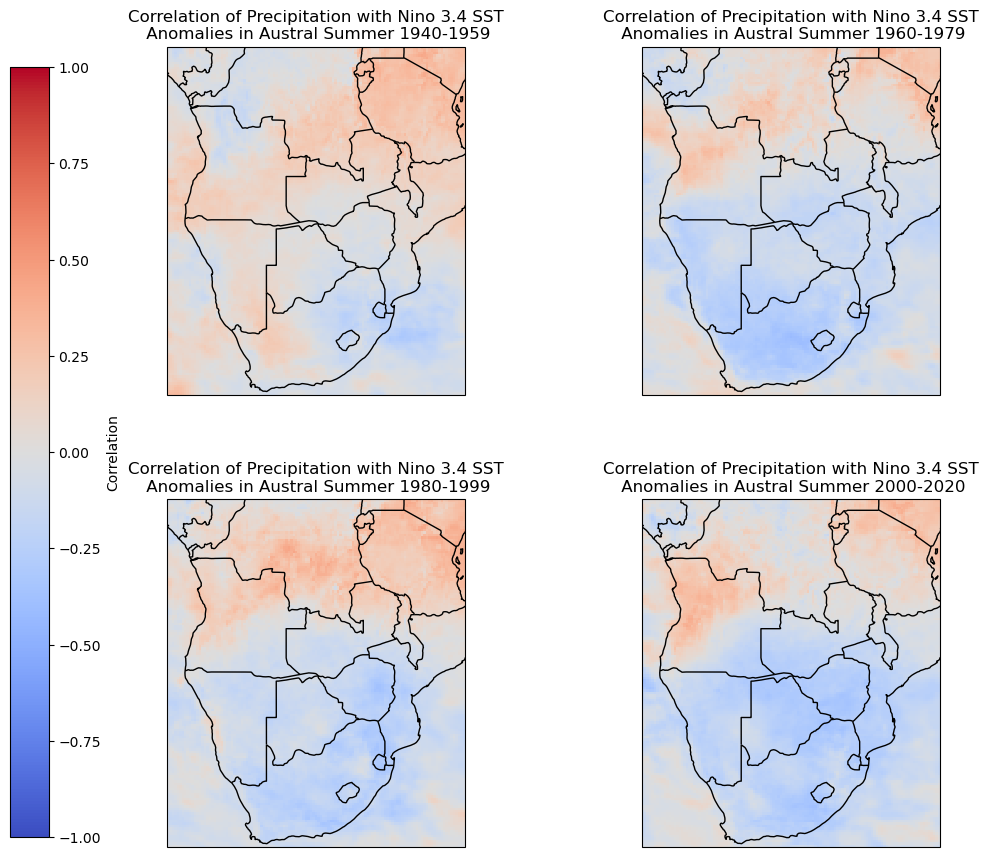

In [10]:
decades = [(1940, 1959), (1960, 1979), (1980, 1999), (2000, 2020)]
titles = ['1940-1959', '1960-1979', '1980-1999', '2000-2020']

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()  # Flatten to easily iterate over axes

# Loop over each decade
for i, (start_year, end_year) in enumerate(decades):
    # Subset data for the specific decade
    mask = (o_f_precip_sa['date'].dt.year >= start_year) & (o_f_precip_sa['date'].dt.year <= end_year)

    # Subset data for the specific decade
    o_f_precip_sa_decade = o_f_precip_sa.sel(date=mask)
    o_f_nino34_decade = o_f_nino34.sel(date=mask)
    
    # Calculate correlation
    correlation_decade = xr.corr(o_f_nino34_decade, o_f_precip_sa_decade['tp'], dim='date')
    
    # Plot correlation
    im = correlation_decade.plot(ax=axes[i], cmap='coolwarm', vmin=-1, vmax=1, add_colorbar=False)
    axes[i].coastlines()
    axes[i].add_feature(cfeature.BORDERS)
    axes[i].set_title(f'Correlation of Precipitation with Nino 3.4 SST\n Anomalies in Austral Summer {titles[i]}')

# Adjust layout
cbar = fig.colorbar(im, ax=axes, orientation='vertical', pad=.2, fraction=1)
cbar.set_label('Correlation')

plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.3)

plt.savefig('/home/k16v981/my_work/figures/southern_africa/dec_sst_nino_oct_feb.jpg', format='jpg')

plt.show()